# Interest Rates

<IPython.core.display.Javascript object>


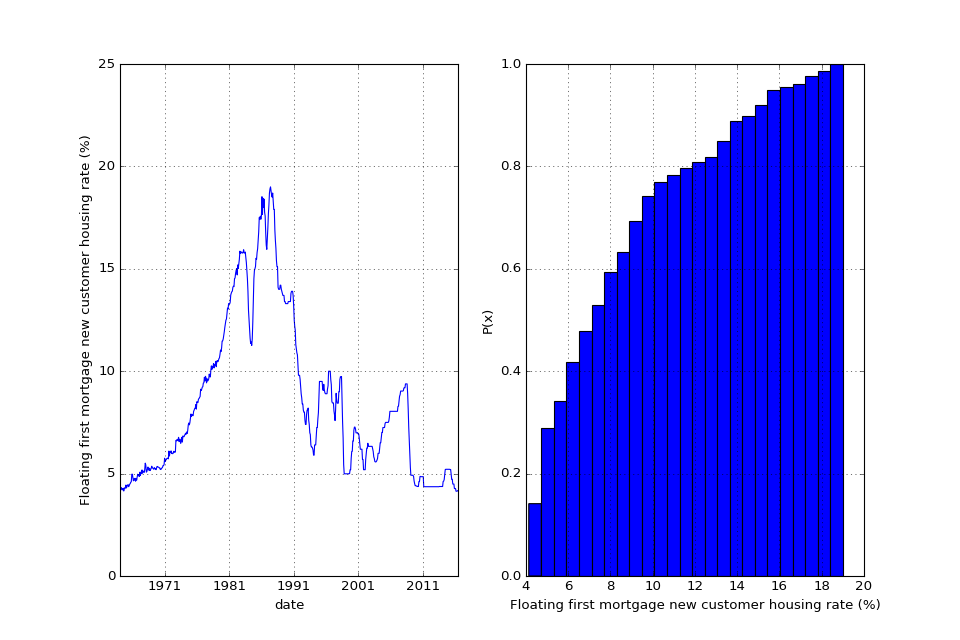

{'std': 3.8779561492414603, 'amin': 4.1399999999999997, 'amax': 19.0, 'mean': 8.4577301587301594}


In [6]:
from matplotlib import pyplot as plt
from pylab import *
from datetime import datetime
from ipywidgets import interact, IntSlider

%matplotlib notebook


# load the data
fudge_factor = 1.5 # even I think these rates are a bit too high, so I fudge them down a bit here to what I see
data = genfromtxt('rates.csv', delimiter=',', dtype=None, names=['date', 'rate'])
dates = [datetime.strptime(d[0], '%b %Y') for d in data]
rates = array([float(d[1]) for d in data]) - fudge_factor


# create a graphs
fig = plt.figure(figsize=[12,8])

ax0 = fig.add_subplot(121)
rates_trace = ax0.plot([], [])[0]
ax0.set_xlabel('date')
ax0.set_ylabel('Floating first mortgage new customer housing rate (%)')
ax0.grid(True)

ax1 = fig.add_subplot(122)

_rates = []
_dates = []
def update_rates_summaries(y0, y1):
    global _rates, _dates
    y0, y1 = (y0, y1) if y1 >= y0 else (y1, y0)
    _dates = dates[y0: y1]
    _rates = rates[y0: y1]
    
    rates_trace.set_data(_dates, _rates)
    ax0.set_xlim([_dates[0], _dates[-1]])
    ax0.set_ylim([0, 25])
    
    ax1.cla()
    ax1.hist(_rates, bins=25, normed=True, cumulative=True)
    print {f.func_name: f(_rates) for f in [mean, std, amin, amax]}
    ax1.set_xlabel('Floating first mortgage new customer housing rate (%)')
    ax1.set_ylabel('P(x)')
    ax1.grid(True)
    
    plt.draw()

update_rates_summaries(0, len(dates))


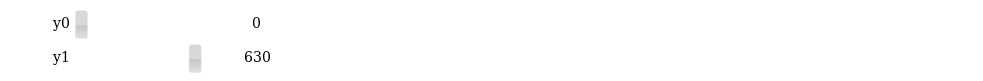

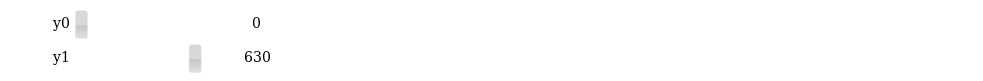

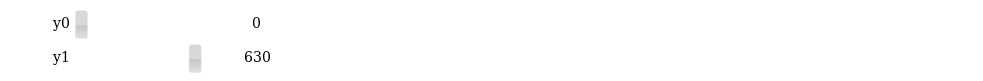

{'std': 3.8779561492414603, 'amin': 4.1399999999999997, 'amax': 19.0, 'mean': 8.4577301587301594}


<function __main__.update_rates_summaries>

In [2]:
from IPython.display import display

tool = interact(update_rates_summaries,y0=IntSlider(min=0,max=len(dates),step=1,value=0), y1=IntSlider(min=0,max=len(dates),step=1,value=len(dates)))
display(tool)

# Monte Carlo random sampling of the interest rates

[  4.14     4.7344   5.3288   5.9232   6.5176   7.112    7.7064   8.3008
   8.8952   9.4896  10.084   10.6784  11.2728  11.8672  12.4616  13.056
  13.6504  14.2448  14.8392  15.4336  16.028   16.6224  17.2168  17.8112
  18.4056  19.    ]


<IPython.core.display.Javascript object>


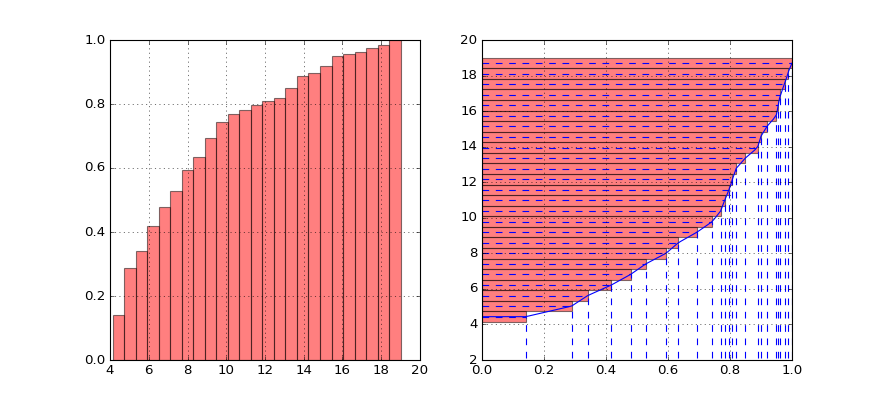

In [3]:
#@todo get this from update_rates_summaries
n, bins, patches = ax0.hist(_rates, bins=25, normed=True, cumulative=True)
print bins

# build function the given a probability between 0..1.0 turns that back into
# an interest rate so we can randomly sample the interest rates from our data
from scipy import interpolate
bin_centers = [b0 + w/2.0 for b0,w in zip(bins,diff(bins))]
f = interpolate.interp1d(n, bin_centers, bounds_error=False, fill_value=(amin(bin_centers), amax(bin_centers)))

fig = figure(figsize=[11  , 5])
ax0 = subplot(121)
ax0.bar(bins[0:-1], n, width=diff(bins), color='r', alpha=0.5)
grid(True)

ax1 = subplot(122)
hold(True)
ax1.barh(bins[0:-1], n, height=diff(bins), color='r', alpha=0.5)
for p in n:
    rate = f(p)
    ax1.plot([p, p], [min(bins) - 2, rate], '--b')
    ax1.plot([0, p], [rate, rate], '--b')
p = arange(0, 1.01, 0.01)
ax1.plot(p, f(p), 'b')
hold(False)
grid(True)

# Home Loan Repayment Model

This is a very simple repayment model, where the interest compounds and repayments are made at each epoch

In [4]:
from numpy import nan
def simloan(principal, repayments, interest_rates, max_epochs=30):
    """
    repay the load until the principal hits $0
    returns the principle, repayment, and interest rates for the loan
    """
    P = [principal,]
    R = [0,]
    I = [0,]
    for e in range(max_epochs):
        if P[-1] < 0:
            R[-1] += P[-1]
            P[-1] = 0
            break
        # add on interest for this epoch
        I.append(interest_rates.next())
        P.append( P[-1] * (1.0 + I[-1]) )       
        # remove repayment for this epoch
        R.append(repayments.next())
        P[-1] -= R[-1]
    return (P,R,I)

# lets do a little simulation to see if our model is sane, ie loan with constant interest and constant repayments
repayments = (50e3 for x in range(100))
interest_rates = (mean(_rates)/100.0 for x in range(100))
(P,R,I) = simloan(500e3, repayments, interest_rates)
if True:
    for n, (p,r,i) in enumerate(zip(P,R,I)):
        print "epoch {}: principle: {:,.2f}, repayment: {}, interest_rate: {}".format(n, p, r, i, grouping=True)
print "Loan payed off in {} epochs, Total repayments ${:,.2f}".format(len(P)-1, sum(R), grouping=True)

epoch 0: principle: 500,000.00, repayment: 0, interest_rate: 0
epoch 1: principle: 492,288.65, repayment: 50000.0, interest_rate: 0.0845773015873
epoch 2: principle: 483,925.10, repayment: 50000.0, interest_rate: 0.0845773015873
epoch 3: principle: 474,854.18, repayment: 50000.0, interest_rate: 0.0845773015873
epoch 4: principle: 465,016.06, repayment: 50000.0, interest_rate: 0.0845773015873
epoch 5: principle: 454,345.86, repayment: 50000.0, interest_rate: 0.0845773015873
epoch 6: principle: 442,773.21, repayment: 50000.0, interest_rate: 0.0845773015873
epoch 7: principle: 430,221.77, repayment: 50000.0, interest_rate: 0.0845773015873
epoch 8: principle: 416,608.77, repayment: 50000.0, interest_rate: 0.0845773015873
epoch 9: principle: 401,844.42, repayment: 50000.0, interest_rate: 0.0845773015873
epoch 10: principle: 385,831.33, repayment: 50000.0, interest_rate: 0.0845773015873
epoch 11: principle: 368,463.91, repayment: 50000.0, interest_rate: 0.0845773015873
epoch 12: principle: 3

OK so we are all setup .. lets run a a monte carl sim by using our f() to generate realistic interest rates and run that over lots of simloans

<IPython.core.display.Javascript object>


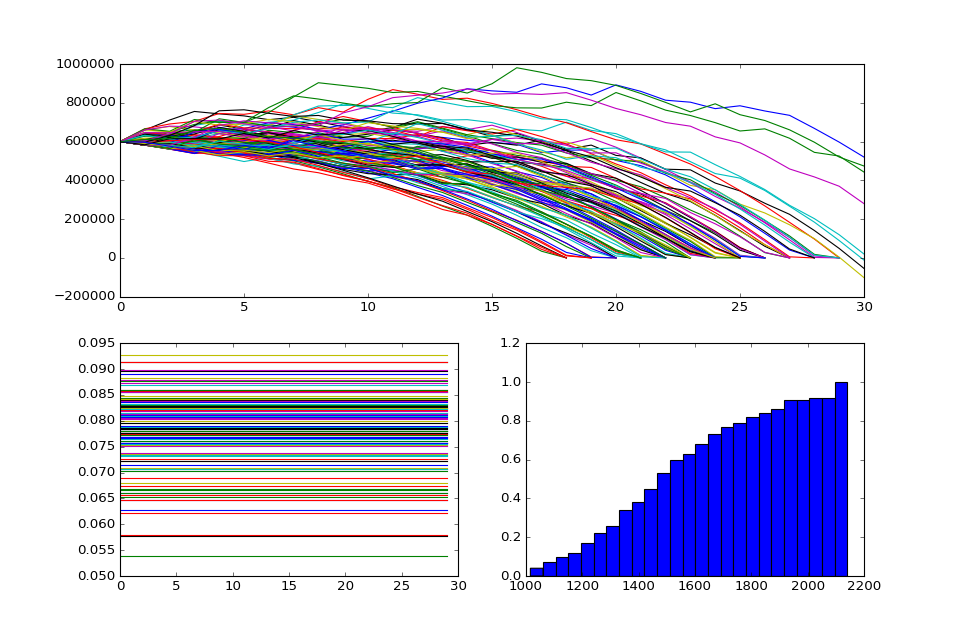

0/100 odds of default, and 5/100 odds of failed to repay by EOL


In [5]:
principle = 600e3 # how much we want to borrow

repayments_simple = (50e3 for x in xrange(10000)) # simple fixed repayments each year
def repayment_with_payrise(start):
    while True:
        yield start
        start += 0.03*start

run = []
totals = []
uI = []
N = 100
defaults = 0
failed = 0
for r in range(N):
    repayments = repayment_with_payrise(45e3)
    interest_rates = (f(rand())/100.0 for x in xrange(10000)) # monte carlo sampled from our histogram (see above)
    (P,R,I) = simloan(principle, repayments, interest_rates)
    if P[-1] >= principle:
        defaults += 1
    if P[-1] >= 0.1:
        failed += 1
    run.append((P,R,I))
    totals.append(sum(R))
    uI.append(mean(I))

fig = figure(figsize=[12,8])
ax0 = subplot(211)
ax1 = subplot(223)
ax2 = subplot(224)
ax0.hold(True); ax1.hold(True); ax2.hold(True)
for r, tot, ui in zip(run, totals, uI):
    (P,R,I) = r
    ax0.plot(P)
    ax1.plot(ui * ones(30), '')
ax2.hist(array(totals)/1e3, bins=25, normed=True,cumulative=True)
ax0.hold(False); ax1.hold(False); ax2.hold(False);
print "{}/{} odds of default, and {}/{} odds of failed to repay by EOL".format(defaults, N, failed, N)
